## Convolutional Neural Networks

## Project: Dog Breed Classifier

---

At the end of this project, the code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

We break the notebook into separate steps.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write Final Algorithm
* [Step 6](#step6): Test Final Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from sklearn.datasets import load_files 
from tensorflow import keras      
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/content/gdrive/My Drive/dogImages/train')
valid_files, valid_targets = load_dataset('/content/gdrive/My Drive/dogImages/valid')
test_files, test_targets = load_dataset('/content/gdrive/My Drive/dogImages/test')

# load list of dog names
dog_names = [item[45:-1] for item in sorted(glob("/content/gdrive/My Drive/dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/content/gdrive/My Drive/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13253 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.


Number of faces detected: 1


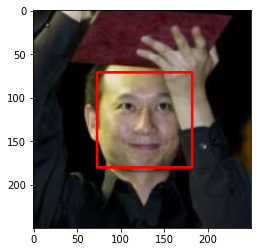

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                              

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('/content/gdrive/My Drive/haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[8])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [6]:
# Testing the performance of face_detector function  on first 100 images of human_files and dog_files
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

is_human = 0
is_dog = 0

for human in  human_files_short:
  is_human += int(face_detector(human))
for dog in  dog_files_short:
  is_dog += int(face_detector(dog))
  
print("humans detected in human_files_short:{}%".format(is_human))
print("humans detected in dogs_files_short:{}%".format(is_dog))

humans detected in human_files_short:100%
humans detected in dogs_files_short:12%


<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/). Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [13]:
from tensorflow.keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102981632/102967424 [==============================] - 1s 0us/step


In [14]:
# Data Preprocessing
# Keras CNNs require a 4D array (tensor) as input
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [15]:
from tensorflow.keras.applications.resnet50 import preprocess_input

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path)) # converts RGB to BGR and normalized by subtracting mean pixel
    return np.argmax(ResNet50_model.predict(img))

In [16]:
# Dog detector
# returns "True" if a dog is detected in the image stored at img_path
# in imagenet categories corresponding to dogs appear from dictionary keys 151-268
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Test the Dog Detector



In [17]:
# Testing the performance of the dog_detector function on the images in human_files_short and dog_files_short.

dogs_in_human_files = 0
dogs_in_dogs_files = 0

for human_img in human_files_short:
  dogs_in_human_files += int(dog_detector(human_img))
for dog_img in dog_files_short:
  dogs_in_dogs_files += int(dog_detector(dog_img))
  
print("Dogs in human_file_short file: {}%".format(dogs_in_human_files))
print("Dogs in dogs_file_short file: {}%".format(dogs_in_dogs_files))

Dogs in human_file_short file: 2%
Dogs in dogs_file_short file: 100%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)
In this step, we will create a CNN (from Scratch) that classifies dog breeds.  

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 103.32it/s]


### Model Architecture


In [19]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

print(train_tensors.shape)
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.4))

model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))


model.summary()

(6680, 224, 224, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 

### Compile the Model

In [20]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Training the model. Useing model checkpointing to save the model that attains the best validation loss.


In [21]:
from keras.callbacks import ModelCheckpoint  
epochs = 30
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/30
334/334 [==============================] - 18s 43ms/step - loss: 4.8743 - accuracy: 0.0108 - val_loss: 4.8476 - val_accuracy: 0.0156

Epoch 00001: val_loss improved from inf to 4.84757, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 2/30
334/334 [==============================] - 14s 41ms/step - loss: 4.8116 - accuracy: 0.0174 - val_loss: 4.8115 - val_accuracy: 0.0168

Epoch 00002: val_loss improved from 4.84757 to 4.81147, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 3/30
334/334 [==============================] - 14s 41ms/step - loss: 4.7769 - accuracy: 0.0198 - val_loss: 4.7780 - val_accuracy: 0.0216

Epoch 00003: val_loss improved from 4.81147 to 4.77797, saving model to saved_models/weights.best.from_scratch.hdf5
Epoch 4/30
334/334 [==============================] - 14s 41ms/step - loss: 4.7445 - accuracy: 0.0204 - val_loss: 4.7587 - val_accuracy: 0.0240

Epoch 00004: val_loss improved from 4.77797 to 4.75866, saving model to save

### Load the Model with the Best Validation Loss

In [22]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

In [23]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 11.2440%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds (Transfer Learning)

###VGG16 Model

Obtain Bottleneck Features

In [24]:
# Bottleneck Features are computed and stored in DogVGG16Data.npz file
bottleneck_features = np.load('/content/gdrive/My Drive/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The last convolutional output of VGG-16 is fed as input to our model.  We only add a dense layer with 500 nodes (LeakyReLu as actvation) followed by a dropout layer with dr = 0.2, BatchNormalization, a global average pooling layer and a fully connected layer equipped with a softmax.

In [26]:
from keras.layers import BatchNormalization, LeakyReLU
VGG16_model = Sequential()
VGG16_model.add(Dense(500, input_shape=(train_VGG16.shape[1:])))
VGG16_model.add(LeakyReLU())
VGG16_model.add(Dropout(0.2))
VGG16_model.add(BatchNormalization())
VGG16_model.add(GlobalAveragePooling2D())
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 7, 7, 500)         256500    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 500)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 500)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 500)         2000      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               66633     
Total params: 325,133
Trainable params: 324,133
Non-trainable params: 1,000
____________________________________________

### Compile the Model

In [27]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [28]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/20
334/334 [==============================] - 4s 8ms/step - loss: 2.2099 - accuracy: 0.5433 - val_loss: 1.2305 - val_accuracy: 0.7030

Epoch 00001: val_loss improved from inf to 1.23053, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 2/20
334/334 [==============================] - 2s 7ms/step - loss: 0.9198 - accuracy: 0.8024 - val_loss: 0.9303 - val_accuracy: 0.7449

Epoch 00002: val_loss improved from 1.23053 to 0.93025, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 3/20
334/334 [==============================] - 2s 7ms/step - loss: 0.5791 - accuracy: 0.8775 - val_loss: 0.8407 - val_accuracy: 0.7677

Epoch 00003: val_loss improved from 0.93025 to 0.84065, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 4/20
334/334 [==============================] - 2s 7ms/step - loss: 0.4046 - accuracy: 0.9145 - val_loss: 0.7922 - val_accuracy: 0.7665

Epoch 00004: val_loss improved from 0.84065 to 0.79215, saving model to saved_models/weights.best.VGG16.h

### Load the Model with the Best Validation Loss

In [29]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model


In [30]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 77.0335%


### Predict Dog Breed with the Model

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/')
from extract_bottleneck_features import *

#using extract_VGG16() function from extract_bottleneck_features.py to obtain bottleneck features for any data
def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)] 

## ResNet50

In [52]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
# Bottleneck Features are computed and stored in DogResnet50Data.npz file
bottleneck_features = np.load('/content/gdrive/MyDrive/DogResnet50Data.npz')
train_Res50 = bottleneck_features['train']
valid_Res50 = bottleneck_features['valid']
test_Res50 = bottleneck_features['test']

### Model Architecture

The last convolutional output of ResNet50 is fed as input to our model.  We only add a dense layer with 500 nodes (LeakyReLu as actvation) followed by a dropout layer with dr = 0.2, BatchNormalization, a global average pooling layer and a fully connected layer equipped with a softmax.


In [54]:
from keras.layers import BatchNormalization, LeakyReLU

print(train_Res50.shape)
Res50_model = Sequential()
Res50_model.add(Dense(500, input_shape=(train_Res50.shape[1:])))
Res50_model.add(LeakyReLU())
Res50_model.add(Dropout(0.2))
Res50_model.add(BatchNormalization())

Res50_model.add(GlobalAveragePooling2D())
Res50_model.add(Dense(133, activation='softmax'))

Res50_model.summary()

(6680, 1, 1, 2048)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1, 1, 500)         1024500   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1, 1, 500)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 500)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1, 1, 500)         2000      
_________________________________________________________________
global_average_pooling2d_4 ( (None, 500)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 133)               66633     
Total params: 1,093,133
Trainable params: 1,092,133
Non-trainable params: 1,000
_____________________

### Compile the Model

In [55]:
Res50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model



In [56]:
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Res50.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=5)

history = Res50_model.fit(train_Res50, train_targets, 
          validation_data=(valid_Res50, valid_targets),
          epochs=20, batch_size=50, callbacks=[checkpointer, earlystop], verbose=1)

Epoch 1/20
134/134 [==============================] - 2s 8ms/step - loss: 1.4431 - accuracy: 0.6398 - val_loss: 0.8586 - val_accuracy: 0.7449

Epoch 00001: val_loss improved from inf to 0.85857, saving model to saved_models/weights.best.Res50.hdf5
Epoch 2/20
134/134 [==============================] - 1s 7ms/step - loss: 0.4457 - accuracy: 0.8754 - val_loss: 0.8243 - val_accuracy: 0.7593

Epoch 00002: val_loss improved from 0.85857 to 0.82434, saving model to saved_models/weights.best.Res50.hdf5
Epoch 3/20
134/134 [==============================] - 1s 7ms/step - loss: 0.2326 - accuracy: 0.9380 - val_loss: 0.7310 - val_accuracy: 0.7952

Epoch 00003: val_loss improved from 0.82434 to 0.73098, saving model to saved_models/weights.best.Res50.hdf5
Epoch 4/20
134/134 [==============================] - 1s 7ms/step - loss: 0.1397 - accuracy: 0.9672 - val_loss: 0.7912 - val_accuracy: 0.7784

Epoch 00004: val_loss did not improve from 0.73098
Epoch 5/20
134/134 [==============================] - 

### Load the Model with the Best Validation Loss

In [57]:
Res50_model.load_weights('saved_models/weights.best.Res50.hdf5')

### Test the Model


In [58]:
# get index of predicted dog breed for each image in test set
Res50_predictions = [np.argmax(Res50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Res50]

# test accuracy
test_accuracy = 100*np.sum(np.array(Res50_predictions)==np.argmax(test_targets, axis=1))/len(Res50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.9043%


### Predict Dog Breed with the Model


In [59]:
def Res50_predict_dog_breed(image_path):
    #using extract_Resnet50() function from extract_bottleneck_features.py to obtain bottleneck features for any data
    bottleneck_features = extract_Resnet50(path_to_tensor(image_path))
    prediction = Res50_model.predict(bottleneck_features)
    return dog_names[np.argmax(prediction)]

## VGG19

In [41]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [42]:
# Bottleneck Features are computed and stored in DogResnet50Data.npz file
bottleneck_features = np.load('/content/gdrive/MyDrive/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

### Model Architecture

The last convolutional output of VGG19 is fed as input to our model.  We only add a dense layer with 500 nodes (LeakyReLu as actvation) followed by a dropout layer with dr = 0.2, BatchNormalization, a global average pooling layer and a fully connected layer equipped with a softmax.

In [43]:
print(train_VGG19.shape)
VGG19_model = Sequential()
VGG19_model.add(Dense(500, input_shape=(train_VGG19.shape[1:])))
VGG19_model.add(LeakyReLU())
VGG19_model.add(Dropout(0.2))
VGG19_model.add(BatchNormalization())

VGG19_model.add(GlobalAveragePooling2D())
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

(6680, 7, 7, 512)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 7, 7, 500)         256500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 500)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 7, 7, 500)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 7, 7, 500)         2000      
_________________________________________________________________
global_average_pooling2d_3 ( (None, 500)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 133)               66633     
Total params: 325,133
Trainable params: 324,133
Non-trainable params: 1,000
__________________________

### Compile the model

In [44]:
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model.

In [45]:
from keras.callbacks import EarlyStopping

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(patience=5)

history = VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=50, callbacks=[checkpointer, earlystop], verbose=1)

Epoch 1/20
134/134 [==============================] - 3s 14ms/step - loss: 2.3012 - accuracy: 0.5542 - val_loss: 1.1158 - val_accuracy: 0.7293

Epoch 00001: val_loss improved from inf to 1.11577, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 2/20
134/134 [==============================] - 2s 12ms/step - loss: 0.9148 - accuracy: 0.8202 - val_loss: 0.8384 - val_accuracy: 0.7737

Epoch 00002: val_loss improved from 1.11577 to 0.83836, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 3/20
134/134 [==============================] - 2s 12ms/step - loss: 0.5633 - accuracy: 0.8864 - val_loss: 0.7443 - val_accuracy: 0.7976

Epoch 00003: val_loss improved from 0.83836 to 0.74434, saving model to saved_models/weights.best.VGG19.hdf5
Epoch 4/20
134/134 [==============================] - 2s 12ms/step - loss: 0.3746 - accuracy: 0.9295 - val_loss: 0.6891 - val_accuracy: 0.7964

Epoch 00004: val_loss improved from 0.74434 to 0.68913, saving model to saved_models/weights.best.VGG

### Load the model weights with the best validation loss.

In [46]:
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

### Test the model

In [47]:
predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
print('Test accuracy: %.4f%%' % test_accuracy)         

Test accuracy: 79.4258%


### Predict dog breed with model

In [48]:
def VGG19_predict_dog_breed(image_path):
     #using extract_VGG19 function from extract_bottleneck_features.py to obtain bottleneck features for any data
    bottleneck_features = extract_VGG19(path_to_tensor(image_path))
    prediction = VGG19_model.predict(bottleneck_features)
    return dog_names[np.argmax(prediction)]

---
<a id='step5'></a>
## Step 5: Write final Algorithm


- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


In [60]:
from tensorflow.keras.applications.resnet50 import ResNet50
# define ResNet50 model
ResNet50_original_model = ResNet50(weights='imagenet')

In [61]:
def show_image(image_path):
    img = cv2.imread(image_path)
    to_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(to_rgb)
    plt.show()

In [62]:
def path_to_tensor_Res(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [64]:
from tensorflow.keras.applications.resnet50 import preprocess_input , decode_predictions 

def Resnet_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor_Res(img_path))
    
    prediction = ResNet50_original_model.predict(img)
    
    # Get the predicted classes and the accuracy
    decoded_class = decode_predictions(prediction)
    
    # Get the class with the highest accuracy
    class_predicted = max(decoded_class[0], key=lambda a:a[2])
    
    class_id = np.argmax(prediction)
    
    # Create an object with the information of the predicted class
    predicted = {'id': class_id,
                 'name': class_predicted[1],
                 'acc': '{:.4g}%'.format(class_predicted[2] * 100)}
    
    return predicted

In [65]:
# Return True if the class is a dog, otherwise return False
def is_dog(class_id):
    return ((class_id >= 151) & (class_id <= 268))

In [69]:
# This function use the face_detector to detect is the image is a human face
# otherwise use a the Resnet_predict_labels function to detect if is a dog or not

def predict_image(image_path):
    if face_detector(image_path):
        print("This is a human and looks like a {}".format(VGG19_predict_dog_breed(image_path)))
    else:
        # Get the class information
        prediction = Resnet_predict_labels(image_path)
        
        if is_dog(prediction['id']):
            # Print the predicted breed using our model, and the label with the accuracy predicted by the ResNet50
            print("It's a Dog : {} ({}, {})".format(VGG19_predict_dog_breed(image_path), prediction['name'], prediction['acc']))
        else:
            print("This is not a human nor a dog, perhaps a {} ({})".format(prediction['name'], prediction['acc']))
        
    # Plot the image
    show_image(image_path)

---
<a id='step6'></a>
## Step 6: Test final Algorithm


In [67]:
from google.colab import files
uploaded = files.upload()

Saving test1.png to test1.png
Saving test2.PNG to test2.PNG
Saving test3.PNG to test3.PNG
Saving test4.png to test4.png
Saving test5.PNG to test5.PNG
Saving test6.PNG to test6.PNG


Predicting image: Dog - Brittany_02625
80150528/80134624 [==============================] - 1s 0us/step
It's a Dog : Brittany (Brittany_spaniel, 99.96%)


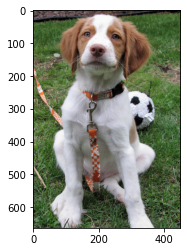

Predicting image: Landscape
This is not a human nor a dog, perhaps a alp (77.91%)


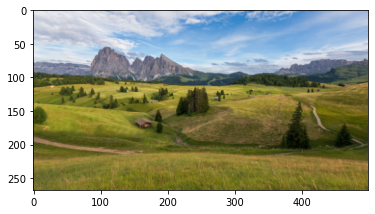

Predicting image: Cat
This is not a human nor a dog, perhaps a tabby (59.48%)


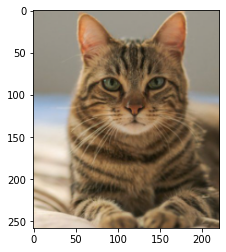

Predicting image: Dog - Alaskan_malamute_00344 
It's a Dog : Alaskan_malamute (malamute, 87.51%)


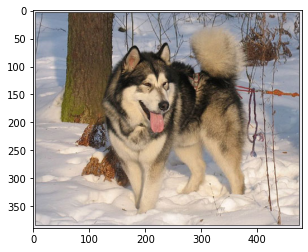

Predicting image: Human
This is a human and looks like a Basenji


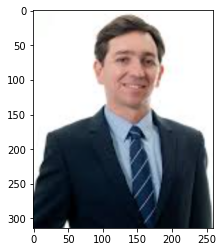

Predicting image: Cat
This is not a human nor a dog, perhaps a Egyptian_cat (36.49%)


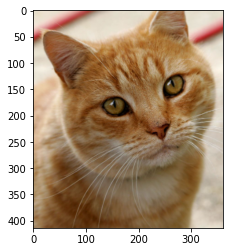

That's all!


In [70]:
images_to_predict = {'/content/test1.png': 'Dog - Brittany_02625',
                    '/content/test2.PNG': 'Landscape',
                    '/content/test3.PNG': 'Cat',
                    '/content/test4.png': 'Dog - Alaskan_malamute_00344 ',
                    '/content/test5.PNG': 'Human',
                    '/content/test6.PNG': 'Cat'}

for path, name in images_to_predict.items():
    print("Predicting image: {}".format(name))
    predict_image(path)

print("That's all!")


